## 1. Introduction et data loading 
This first step consists of importing and examining the dataset, as well as preparing it for exploratory analysis.

#### A. Import library

In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import random as random 
import math

#### B. Import data

In [2]:
df_train = pd.read_csv("train.csv")

In the initial exploration of the dataset, we found that no feature stood out as strongly linked to the target variable. To enable a more meaningful analysis and better apply what we’ve learned, we added an Age column—this new feature should help provide more signal and allow for deeper investigation.

### Creation variable *Age*

In [3]:
np.random.seed(123)
n = len(df_train)

yes = df_train[df_train.Loan_Status=="Y"]
no = df_train[df_train.Loan_Status=="N"]
n_yes = df_train[df_train.Loan_Status=="Y"].shape[0]
n_no = df_train[df_train.Loan_Status=="N"].shape[0]

age_yes = np.concatenate( [np.random.randint(32,58,int(n_yes*0.7)),np.random.randint(18,29,int((n_yes*0.3)+1))])
age_no = np.concatenate( [np.random.randint(32,58,int(n_no*0.2)),np.random.randint(61,85,int(n_no*0.3)),np.random.randint(18,29,int((n_no*0.5)+1))])


mask_yes = df_train.Loan_Status == "Y"
mask_no  = df_train.Loan_Status == "N"

df_train.loc[mask_yes, "age"] = age_yes
df_train.loc[mask_no,  "age"] = age_no




In [4]:
df = df_train.copy()

## 2. Initial Understanding of the Dataset

In [5]:
df.shape

(614, 14)

The table contains 614 rows and 14 columns.

In [6]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
age                  float64
dtype: object

In [7]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,age
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,45.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,48.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,34.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,34.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,38.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
 13  age                614 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 67.3+ KB


## Missing Values

In [9]:
def val_nul_plot(df, title="Percentage of missing values"):

    pct_missing = df.isna().sum() / len(df) * 100
    pct_missing = pct_missing.sort_values(ascending=False)


    for col, prct in pct_missing.items():
        print(f"{col}-------------------- {prct:0.2f} % missing values")


    cmap = plt.get_cmap("Reds")
    max_val = pct_missing.max()
    normed = pct_missing / max_val if max_val > 0 else pct_missing
    colors = [cmap(v) for v in normed]


    fig, ax = plt.subplots(figsize=(8, max(4, len(pct_missing)*0.5)))
    bars = ax.barh(pct_missing.index, pct_missing.values, color=colors, edgecolor="black")
    ax.invert_yaxis() 
    ax.set_xlabel("Percentage of missing values (%)")
    ax.set_title(title)
    ax.set_xlim(0, 100)
    ax.grid(axis="x", linestyle="--", linewidth=0.5, alpha=0.7)


    for bar in bars:
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2,
                f"{width:0.1f}%", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()


    col_val_nul = [col for col, prct in pct_missing.items() if prct > 0]
    return pct_missing, col_val_nul


Credit_History-------------------- 8.14 % missing values
Self_Employed-------------------- 5.21 % missing values
LoanAmount-------------------- 3.58 % missing values
Dependents-------------------- 2.44 % missing values
Loan_Amount_Term-------------------- 2.28 % missing values
Gender-------------------- 2.12 % missing values
Married-------------------- 0.49 % missing values
age-------------------- 0.00 % missing values
Loan_Status-------------------- 0.00 % missing values
Property_Area-------------------- 0.00 % missing values
CoapplicantIncome-------------------- 0.00 % missing values
ApplicantIncome-------------------- 0.00 % missing values
Education-------------------- 0.00 % missing values
Loan_ID-------------------- 0.00 % missing values


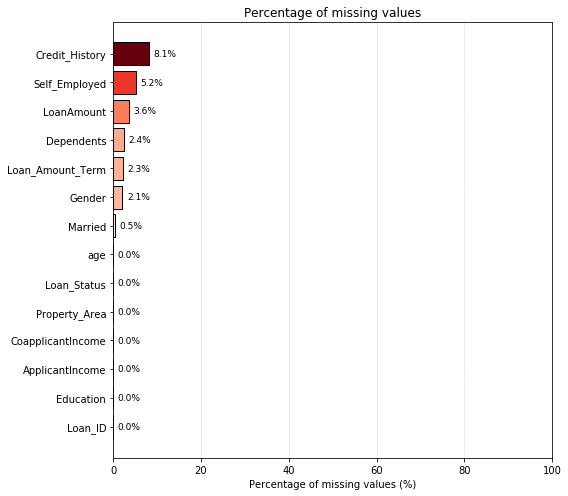

(Credit_History       8.143322
 Self_Employed        5.211726
 LoanAmount           3.583062
 Dependents           2.442997
 Loan_Amount_Term     2.280130
 Gender               2.117264
 Married              0.488599
 age                  0.000000
 Loan_Status          0.000000
 Property_Area        0.000000
 CoapplicantIncome    0.000000
 ApplicantIncome      0.000000
 Education            0.000000
 Loan_ID              0.000000
 dtype: float64,
 ['Credit_History',
  'Self_Employed',
  'LoanAmount',
  'Dependents',
  'Loan_Amount_Term',
  'Gender',
  'Married'])

In [10]:
val_nul_plot(df)

There are 7 columns with missing values, with the column Credit_History having the highest proportion (approximately 8% missing data).

### ID, if no duplicates, we can drop this column

In [11]:
def drop_id(df):
    if not df["Loan_ID"].is_unique:
        print("Duplicates detected. Removing...")
        df = df.drop_duplicates(subset="Loan_ID")
    else:
        print("No duplicates on Loan_ID and we droped this column")
    df = df.drop("Loan_ID", axis=1)
    return df

In [12]:
df = drop_id(df)

No duplicates on Loan_ID and we droped this column


In [13]:
df.duplicated().sum()

0

There are no duplicate rows in the dataset.